In [4]:
from io import open
import glob
import os

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
def findFiles(path): return glob.glob(path)

print(findFiles('/content/gdrive/MyDrive/Practice/Name_classification_example/data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# turn a unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii('Ślusàrski'))

# build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/content/gdrive/MyDrive/Practice/Name_classification_example/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/content/gdrive/MyDrive/Practice/Name_classification_example/data/names/English.txt', '/content/gdrive/MyDrive/Practice/Name_classification_example/data/names/Chinese.txt', '/content/gdrive/MyDrive/Practice/Name_classification_example/data/names/Czech.txt', '/content/gdrive/MyDrive/Practice/Name_classification_example/data/names/Arabic.txt', '/content/gdrive/MyDrive/Practice/Name_classification_example/data/names/Dutch.txt', '/content/gdrive/MyDrive/Practice/Name_classification_example/data/names/Polish.txt', '/content/gdrive/MyDrive/Practice/Name_classification_example/data/names/Korean.txt', '/content/gdrive/MyDrive/Practice/Name_classification_example/data/names/Portuguese.txt', '/content/gdrive/MyDrive/Practice/Name_classification_example/data/names/Japanese.txt', '/content/gdrive/MyDrive/Practice/Name_classification_example/data/names/Spanish.txt', '/content/gdrive/MyDrive/Practice/Name_classification_example/data/names/Scottish.txt', '/content/gdrive/MyDrive/Practice/Name_class

In [8]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [12]:
import torch

# find letter index from all letters
def letterToIndex(letter):
    return all_letters.find(letter)

# just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### Creating the Network


In [13]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [14]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)


In [16]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8191, -2.8038, -2.8510, -2.8159, -2.8927, -2.8643, -2.9362, -2.9204,
         -2.9448, -2.8806, -2.9355, -2.8276, -2.8950, -2.9909, -2.9765, -2.7991,
         -2.9560, -2.9502]], grad_fn=<LogSoftmaxBackward0>)


In [17]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 15)


In [24]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Pezos
category = Italian / line = Turati
category = Greek / line = Gomatos
category = Polish / line = Ziemniak
category = Portuguese / line = Pinho
category = Korean / line = Ho
category = Spanish / line = Herrera
category = English / line = Graves
category = Irish / line = O'Hagan
category = Korean / line = Woo


In [25]:
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


In [28]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # print 'iter' number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100,
                                                timeSince(start), loss, line, guess, correct))

        # add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0


5000 5% (0m 8s) 1.6245 Tessaro / Portuguese ✗ (Italian)
10000 10% (0m 17s) 2.2761 Sulzbach / French ✗ (German)
15000 15% (0m 26s) 1.5648 Abello / Italian ✗ (Spanish)
20000 20% (0m 34s) 2.1988 Silje / English ✗ (Dutch)
25000 25% (0m 43s) 0.2810 Conti / Italian ✓
30000 30% (0m 51s) 0.5832 Herten / Dutch ✓
35000 35% (1m 0s) 4.9180 Roosa / Italian ✗ (Dutch)
40000 40% (1m 8s) 1.4371 Amersvoort / Dutch ✓
45000 45% (1m 19s) 2.8134 Breda / Spanish ✗ (Dutch)
50000 50% (1m 28s) 2.8319 Simodines / Dutch ✗ (Czech)
55000 55% (1m 37s) 2.7813 Albuquerque / French ✗ (Portuguese)
60000 60% (1m 46s) 0.6200 Youn / Korean ✓
65000 65% (1m 54s) 0.7864 Ichigawa / Japanese ✓
70000 70% (2m 3s) 1.8608 Isa / Japanese ✗ (Arabic)
75000 75% (2m 11s) 0.4378 Thi / Vietnamese ✓
80000 80% (2m 20s) 0.2861 Ferreiro / Portuguese ✓
85000 85% (2m 29s) 1.4552 Yong / Korean ✗ (Chinese)
90000 90% (2m 37s) 0.0332 Ashikaga / Japanese ✓
95000 95% (2m 46s) 0.1127 Rosario / Portuguese ✓
100000 100% (2m 54s) 0.3645 Close / Greek ✓


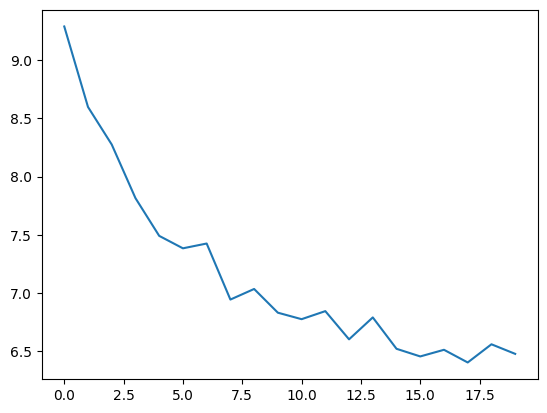

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-32-4ed40b02cee2>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation = 90)
<ipython-input-32-4ed40b02cee2>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


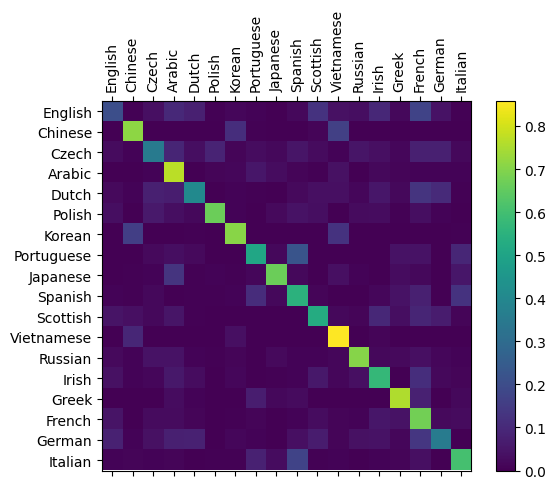

In [32]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# set up axes
ax.set_xticklabels([''] + all_categories, rotation = 90)
ax.set_yticklabels([''] + all_categories)

# force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


In [42]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


predict('Dovesky')
predict('Jackson')
predict('Hiro')
predict('Jihwan')
predict('Hyunbin')
predict('Sang Uk')
predict('Sang Min')


> Dovesky
(-0.32) Russian
(-1.46) Czech
(-4.18) English

> Jackson
(-0.58) Scottish
(-1.59) Arabic
(-2.25) English

> Hiro
(-1.00) Japanese
(-1.53) Portuguese
(-2.20) Italian

> Jihwan
(-0.55) Korean
(-1.09) Chinese
(-2.54) Vietnamese

> Hyunbin
(-0.55) Russian
(-2.30) Arabic
(-2.62) German

> Sang Uk
(-1.02) Polish
(-1.70) English
(-1.91) Czech

> Sang Min
(-1.08) Chinese
(-1.38) Irish
(-1.72) Vietnamese
